In [1]:
import pandas as pd
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

np.set_printoptions(suppress=True)

%matplotlib inline

from sklearn.metrics import confusion_matrix

# Read and Clean Data

In [2]:
input_df = pd.read_csv('train.csv')
input_df.head()

,Tweet,following,followers,actions,is_retweet,location,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality


In [3]:
# Check invalid values in the dataset
input_df.isnull().sum()

Tweet            0
following      158
followers       17
actions       3437
is_retweet       1
location      2011
Type             0
dtype: int64

In [4]:
# Drop columns with too many invalid values
input_df.drop(columns=['location', 'actions'], inplace=True)
input_df.dropna()

,Tweet,following,followers,is_retweet,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,0.0,Spam
2,Haven't been following the news but I understa...,0.0,0.0,0.0,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,0.0,Quality
...,...,...,...,...,...
14894,"#AllWentWrongWhen I told my hair stylist to ""g...",695.0,533.0,1.0,Spam
14895,"They don't have to like you, and you don't hav...",0.0,0.0,0.0,Quality
14896,#Miami Graham Nash Live at Parker Playhouse #...,5647.0,15091.0,0.0,Spam
14897,@bethannhamilton is in the business of one-upp...,0.0,0.0,0.0,Quality


In [5]:
# Drop data points with invalid labels
input_df.drop(input_df[(input_df['Type'] != 'Quality') & (input_df['Type'] != 'Spam')].index, inplace=True)
input_df.Type.unique()

array(['Quality', 'Spam'], dtype=object)

In [6]:
from sklearn import preprocessing

# Encode labels in string format
le = preprocessing.LabelEncoder()
le.fit(input_df.Type.unique().tolist())
print(list(le.classes_))
input_df['Type'] = le.transform(input_df['Type'])

['Quality', 'Spam']


In [7]:
input_df.head()

,Tweet,following,followers,is_retweet,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,0.0,1
2,Haven't been following the news but I understa...,0.0,0.0,0.0,0
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,0.0,0


In [8]:
from nltk.corpus import stopwords

# Drop stopwords in tweets and convert the text to lowercase
filtered_text = []
for i in range(0,len(input_df)):
    word_list = str(input_df.Tweet.iloc[i]).split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_text.append(' '.join(filtered_words))
input_df['filtered_text'] = filtered_text
input_df['filtered_text_lower'] = input_df['filtered_text'].str.lower()

In [9]:
# Add a new feature of the count of numbers in each tweet
digits_list = []
for i in range(0,len(input_df)):
    if(sum(c.isdigit() for c in input_df.Tweet.iloc[i]) == 0):
        digits_list.append(0)
    else:
        digits_list.append(sum(c.isdigit() for c in input_df.Tweet.iloc[i]))

digits_col = pd.Series(digits_list)
input_df['digits'] = digits_col.values

In [10]:
# Add a new feature of the count of uppercase words in each tweet
cap_list = []
for i in range(0,len(input_df)):
    words = input_df.Tweet.iloc[i].split()
    count = 0
    for j in range(0,len(words)):
        if(words[j].isupper()):
            count = count + 1;
    cap_list.append(count)    
    #print(cap_list)
        
cap_col = pd.Series(cap_list)
input_df['cap'] = cap_col.values

In [11]:
input_df.head()

,Tweet,following,followers,is_retweet,Type,filtered_text,filtered_text_lower,digits,cap
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0,Good Morning Love @LeeBrown_V,good morning love @leebrown_v,0,0
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,0.0,1,'@realDonaldTrump @USNavy RIP TO HEROES','@realdonaldtrump @usnavy rip to heroes',0,3
2,Haven't been following the news but I understa...,0.0,0.0,0.0,0,Haven't following news I understand #EFF dumbe...,haven't following news i understand #eff dumbe...,0,2
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0,pic.twitter.com/dy9q4ftLhZ What paper scissors...,pic.twitter.com/dy9q4ftlhz what paper scissors...,2,0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,0.0,0,#DidYouKnow ► Mahatma Gandhi made brief visit ...,#didyouknow ► mahatma gandhi made brief visit ...,6,0


In [12]:
# Separate ham and spam tweets
ham_df = input_df[input_df.Type == le.classes_.tolist().index('Quality')]
spam_df = input_df[input_df.Type == le.classes_.tolist().index('Spam')]

# Only use the same number of ham and spam tweets
ham_df = ham_df.sample(len(spam_df))
df = pd.concat([ham_df, spam_df])
df.head()

,Tweet,following,followers,is_retweet,Type,filtered_text,filtered_text_lower,digits,cap
7749,lucky bitch,0.0,0.0,1.0,0,lucky bitch,lucky bitch,0,0
1129,#AQABiology @AQA too many alcopops?pic.twitter...,0.0,0.0,0.0,0,#AQABiology @AQA many alcopops?pic.twitter.com...,#aqabiology @aqa many alcopops?pic.twitter.com...,5,1
12804,stay with me #방탄소년단 don't let me go #BTS,0.0,0.0,0.0,0,stay #방탄소년단 let go #BTS,stay #방탄소년단 let go #bts,0,1
6855,Is it too late to drop chem????,0.0,0.0,0.0,0,Is late drop chem????,is late drop chem????,0,0
3433,BBC's reports on Angelina Jolie and the Remain...,0.0,0.0,0.0,0,BBC's reports Angelina Jolie Remain campaign r...,bbc's reports angelina jolie remain campaign r...,4,0


In [13]:
print("Number of Spam tweets:",len(spam_df))
print("Number of Ham tweets:",len(ham_df))

Number of Spam tweets: 7443
Number of Ham tweets: 7443


# Exploratory Data Analysis

In [14]:
# Create lists of ham and spam tweets
spam_text = [spam_df.filtered_text.iloc[i] for i in range(0,len(spam_df))]
ham_text = [ham_df.filtered_text.iloc[i] for i in range(0,len(ham_df))]

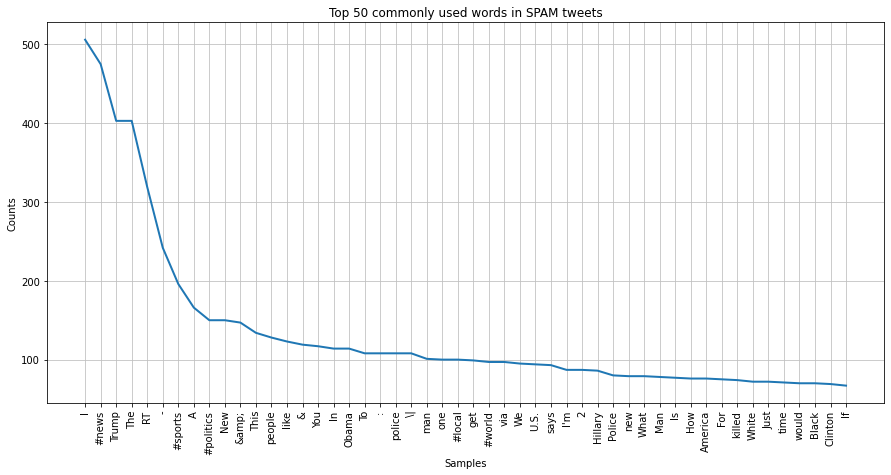

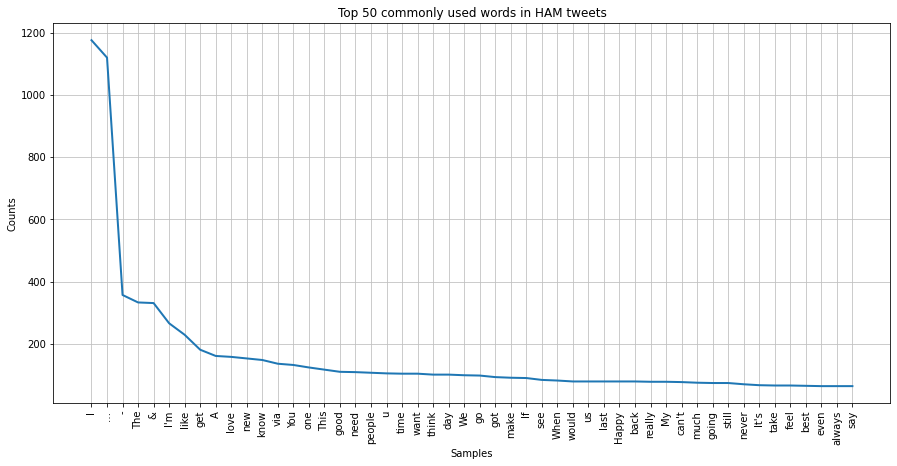

<AxesSubplot:title={'center':'Top 50 commonly used words in HAM tweets'}, xlabel='Samples', ylabel='Counts'>

In [15]:
# Show top 50 commonly used words in SPAM tweets
spam_text = ' '.join(spam_text).split()
freq = nltk.FreqDist(spam_text)

plt.figure(figsize=(15,7))
plt.title("Top 50 commonly used words in SPAM tweets")
freq.most_common(50)
freq.plot(50)

# Show top 50 commonly used words in HAM tweets
ham_text = ' '.join(ham_text).split()
freq = nltk.FreqDist(ham_text)

plt.figure(figsize=(15,7))
plt.title("Top 50 commonly used words in HAM tweets")
freq.most_common(50)
freq.plot(50)

### Word Cloud for Spam Corpus

In [16]:
from wordcloud import (WordCloud, get_single_color_func)

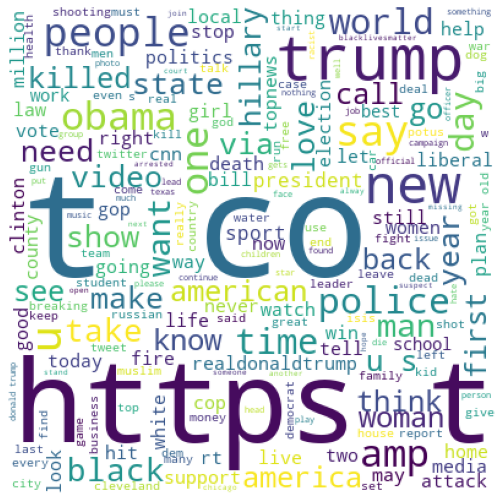

In [17]:
text = ''
for i in range(0,len(spam_df)):
    text = text + str(spam_df.filtered_text_lower.iloc[i])

plt.figure(figsize=(12,9))
wordcloud = WordCloud(background_color='white', width=400, height=400).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word Cloud for Ham Corpus

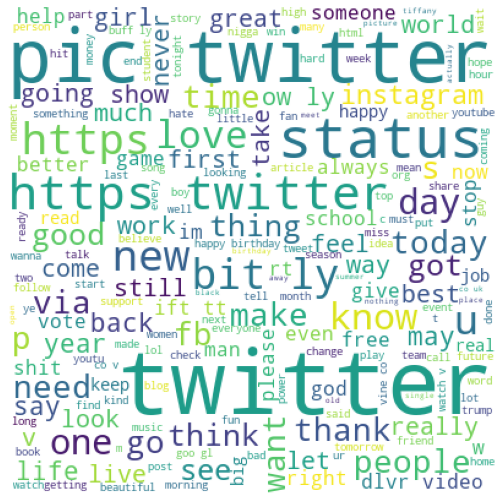

In [18]:
text = ''
for i in range(0,len(ham_df)):
    text = text + str(ham_df.filtered_text_lower.iloc[i])

plt.figure(figsize=(12,9))
wordcloud = WordCloud(background_color='white', width=400, height=400).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

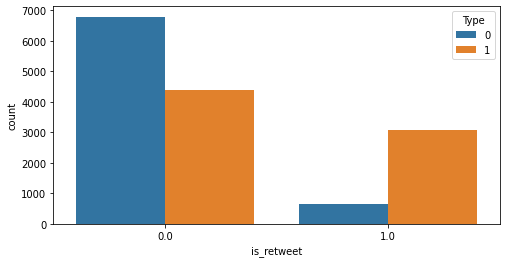

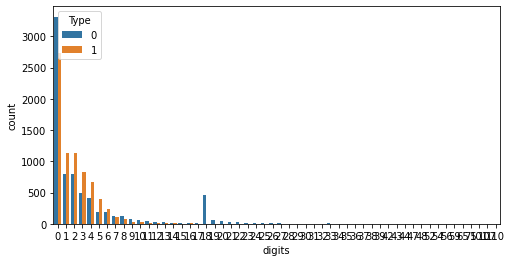

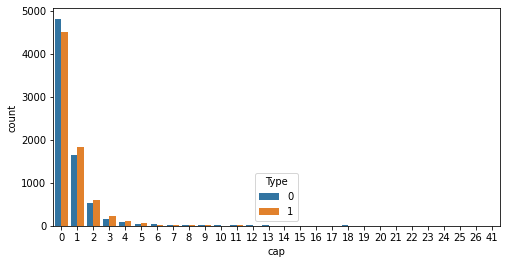

In [19]:
cols = ['is_retweet', 'digits', 'cap']
for i in range(len(cols)):
    plt.figure(figsize=(8,4))
    c = cols[i]
    sns.countplot(x=c, hue=df.Type, data=df)
    plt.show()

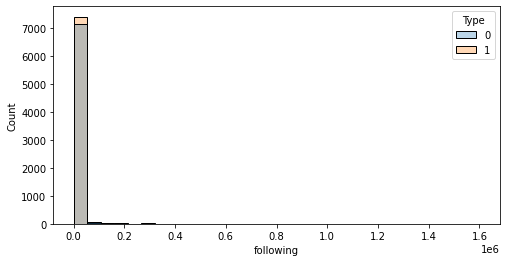

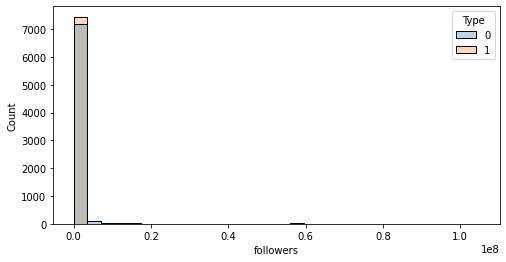

In [20]:
cols = ['following', 'followers']
for i in range(len(cols)):
    plt.figure(figsize=(8,4))
    c = cols[i]
    sns.histplot(x=c, alpha=0.3, hue=df.Type, data=df, bins=30)
    plt.show()

In [21]:
df.var(axis=0, numeric_only=True)

following     9.017407e+08
followers     1.514863e+13
is_retweet    1.875042e-01
Type          2.500168e-01
digits        2.550574e+01
cap           2.823022e+00
dtype: float64

All the non-textual features except for _is_retweet_ are largely overlapped between ham and spam tweets and do not seem very uesful to distinguish between the two classes.

Therefore, I will only use the textual feature. In textual data, it is clear that some words are more frequently used than the other words. TF-IDF Vectorizer will effectively extract meaningful word features.

# Naive Bayes Modeling

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=50)
tfidf_vector = tfidf_vectorizer.fit_transform(df['filtered_text_lower'])

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_vector.toarray(), df.Type, test_size=0.2, random_state=42)

In [24]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [25]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print("F-measure for this model: ", f1*100, "%")

F-measure for this model:  84.89726271620803 %


In [26]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("MAE for this model: ", mae)

MAE for this model:  0.1490933512424446


In [27]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)

TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]

# Sensitivity, hit rate, recall, or true positive rate
recall = TP/(TP+FN)
print("Recall: ",round(recall*100,2),"%")

# Precision or positive predictive value
precision = TP/(TP+FP)
print("Precision: ",round(precision*100,2),"%")

# Accuracy
accuracy = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy: ",round(accuracy*100,2),"%")

Recall:  78.86 %
Precision:  96.13 %
Accuracy:  85.09 %
